In [135]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [136]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [ 2.93888937]

R-squared:
0.897210638179


## Assumptions of Multivariable Linear Regression


### Assumption one: linear relationship



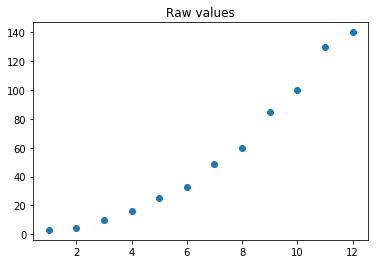

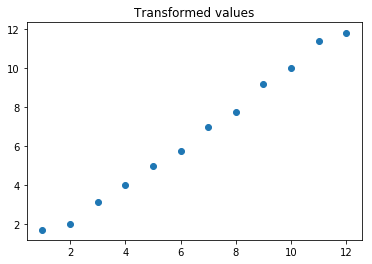

In [137]:
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

When interpreting features with non-linear transformations, it is important to keep the transformation in mind.  For example, in the equation $y = 2log({x})$, y increases by one unit for every two-unit increase in $log({x})$.  The relationship between y and x, however, is non-linear, and the amount of change in y varies based on the absolute value of x:

|x	|log(x)|	y|
|--|--|--|
|1	|0	|0|
|10	|1	|2|
|100	|2	|4|	
|1000|	3	|6|

So a one-unit change in x from 1 to 2 will result in a much greater change in y than a one-unit change in x from 100 to 101.

There are many variable transformations.  For a deep dive, check out the Variable Linearization section of [Fifty Ways to Fix Your Data](https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/).

### Assumption two: multivariate normality

The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed.  Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.  

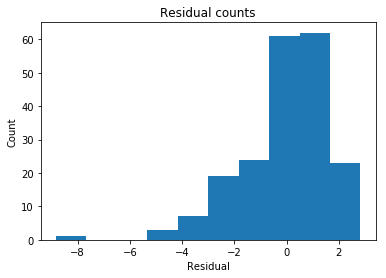

In [138]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


### Assumption three: homoscedasticity

The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance.  This leads to overconfidence in the accuracy of your model's predictions.

Some fixes to heteroscedasticity include transforming the dependent variable and adding features that target the poorly-estimated areas. For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.

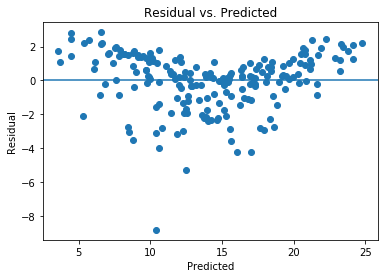

In [139]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

## Assumption four: low multicollinearity
Correlations among features should be low or nonexistent. When features are correlated, they may both explain the same pattern of variance in the outcome. The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained. However, if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

Multicollinearity can be fixed by PCA or by discarding some of the correlated features.

In [140]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


Drill: fixing assumptions
Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality. Use the cell(s) below to see what you can do to fix it.

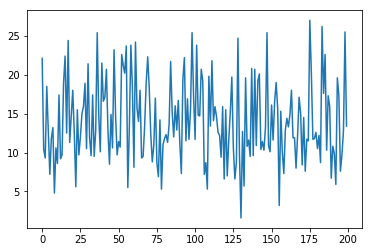

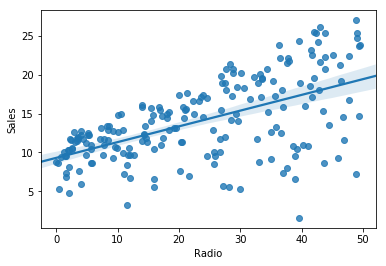

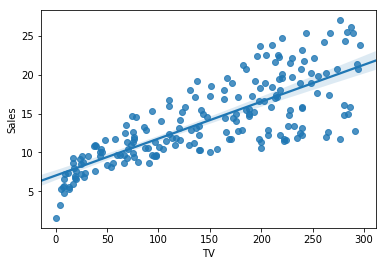

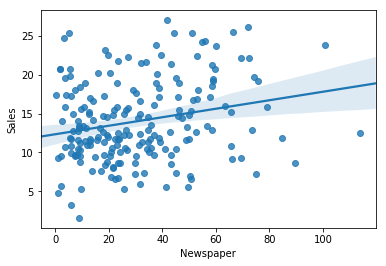

In [141]:
# Your code here.

#Check for linearity between features and outcome.

plt.plot(data['Sales'])
plt.show()

sns.regplot(data['Radio'], data['Sales'])
plt.show()


sns.regplot(data['TV'], data['Sales'])
plt.show()


sns.regplot(data['Newspaper'], data['Sales'])
plt.show()



TV looks okay, Radio is worse and Newspaper needs to be transformed but the data is closest to uniform and I'm not sure how to fix it?
Instead, I'll try try to transform the Sales data using a Box-Cox transformation.

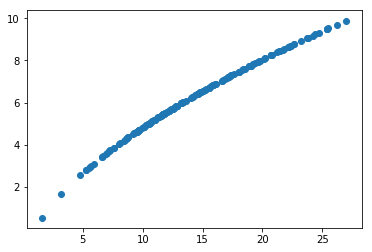

In [142]:
from scipy.stats import boxcox

bc = boxcox(data['Sales'])
# Need to use an index to get the values

plt.scatter(data['Sales'], bc[0])
plt.show()

data['Sales_BC'] = bc[0]



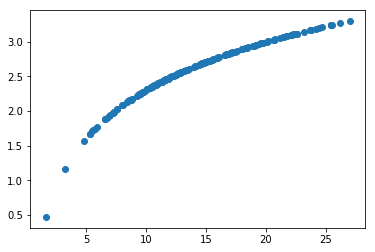

In [143]:
#I'll also take the log to see if it helps
data['Sales_log'] = np.log(data['Sales'])

plt.scatter(data['Sales'], data['Sales_log'])
plt.show()


Box Cox seems like a better candidate.

In [144]:
# Instantiate and fit our model with transformed Box Cox data.
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.0154768   0.0585134   0.00010463]

Intercept: 
 2.44996967639

R-squared:
0.882785717206


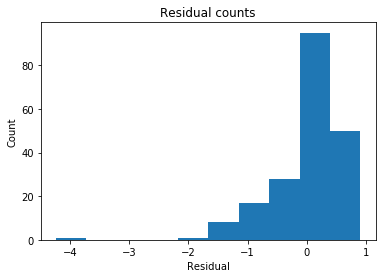

In [145]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Residuals are not normally distrubted and have one large outlier.

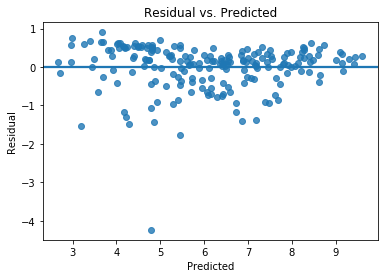

In [146]:
sns.regplot(predicted, residual, ci = False)
plt.xlabel('Predicted')
plt.ylabel('Residual')
#plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()



Homoscedacity appears to be fixed. 

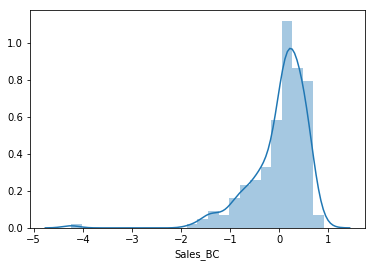

In [147]:
sns.distplot(residual)

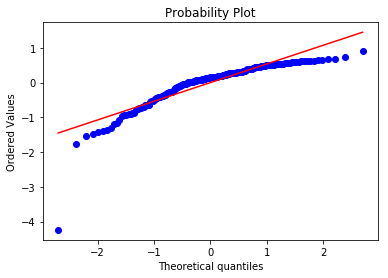

In [148]:
import pylab 
import scipy.stats as stats
  
stats.probplot(residual, plot=pylab)
pylab.show()


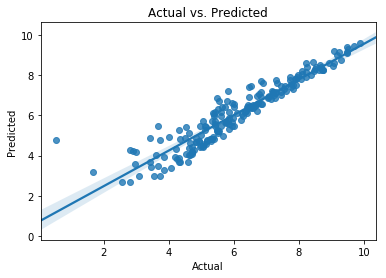

In [149]:

sns.regplot(actual, predicted)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

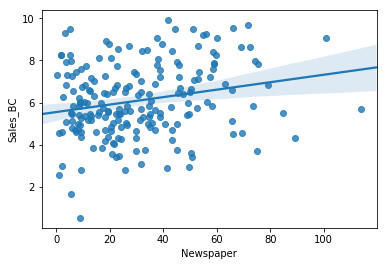

In [150]:
sns.regplot(data['Newspaper'], data['Sales_BC'])
plt.show()

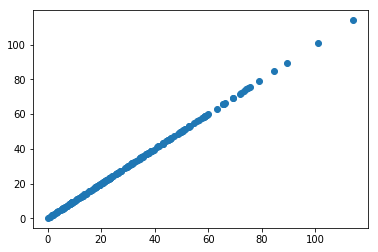

In [151]:
#I'll try to transform the newspaper data with a box cox or Log as well
data['Newspaper_log'] = np.log(data['Newspaper'])

plt.scatter(data['Newspaper'], data['Newspaper'])
plt.show()

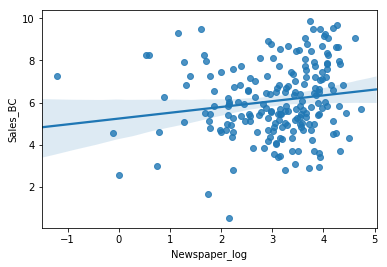

In [152]:
sns.regplot(data['Newspaper_log'], data['Sales_BC'])
plt.show()


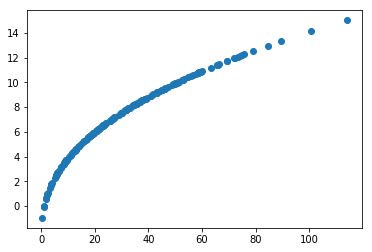

In [153]:
bc = boxcox(data['Newspaper'])
plt.scatter(data['Newspaper'], bc[0])
plt.show()

data['Newspaper_BC'] = bc[0]


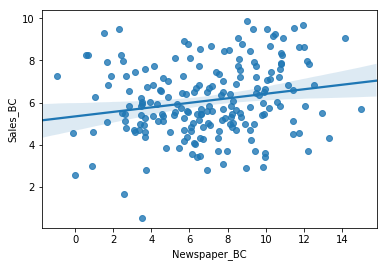

In [154]:
sns.regplot(data['Newspaper_BC'], data['Sales_BC'])
plt.show()


Neither are great. 

In [155]:
# Instantiate and fit our model with transformed Newspaper_log data.
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Radio','Newspaper_log']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01547379  0.0580799   0.03145628]

Intercept: 
 2.36693826293

R-squared:
0.883078710201


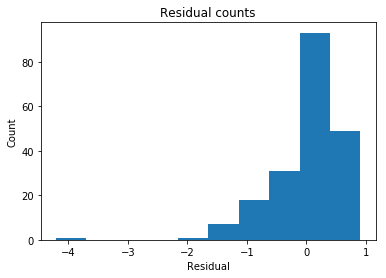

In [156]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

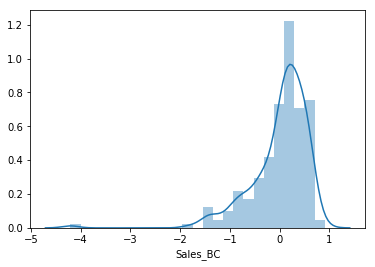

In [157]:
sns.distplot(residual)

In [158]:
# Instantiate and fit our model with transformed Newspaper_BC data.
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Radio','Newspaper_BC']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01547136  0.05814738  0.00650271]

Intercept: 
 2.41746021525

R-squared:
0.88291304123


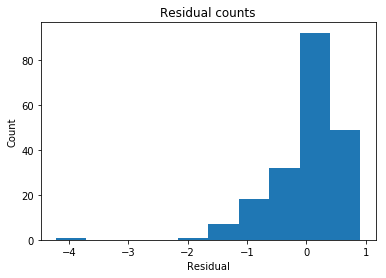

In [159]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

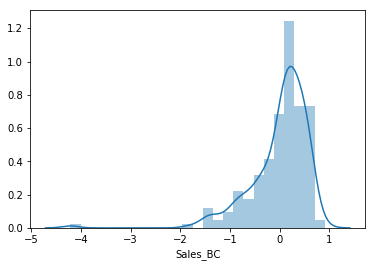

In [160]:
sns.distplot(residual)

In [161]:
print(residual.nsmallest(5))
print(data['Newspaper'][130])
print(data['Newspaper'].nsmallest(5))
print(data['Newspaper'].nlargest(5))


130   -4.214
5     -1.790
155   -1.513
78    -1.458
126   -1.446
Name: Sales_BC, dtype: float64
8.7
33    0.300
65    0.900
8     1.000
139   1.700
42    1.800
Name: Newspaper, dtype: float64
16    114.000
101   100.900
75     89.400
165    84.800
118    79.200
Name: Newspaper, dtype: float64


Neither of my transformations for Newspaper helped with the residuals and the residuals don't seem to match up with any possible outliers in the data.

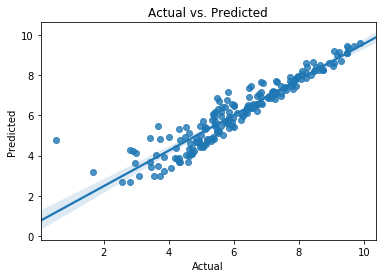

In [162]:

sns.regplot(actual, predicted)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

Using a Box-cox and log transformation on the newspaper variable didn't fix the non-normal residuals and didn't help the model.

In [163]:
# Instantiate and fit our model with transformed Newspaper_BC data.
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Newspaper_BC']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01589101  0.0885718 ]

Intercept: 
 3.14028274248

R-squared:
0.657827849624


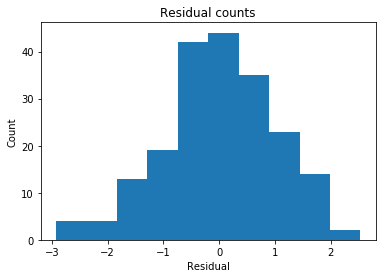

In [164]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

The outliers in the residual is actually being caused by the Radio feature, not the Newspaper.

In [165]:
#data must be positive
data['Radio'].describe()
data['Radio'] = data['Radio'] + 1.6

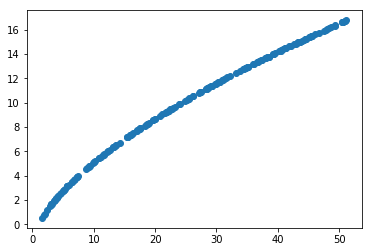

In [166]:
bc = boxcox(data['Radio'])
plt.scatter(data['Radio'], bc[0])
plt.show()

data['Radio_BC'] = bc[0]

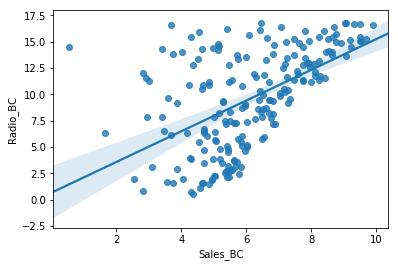

In [172]:
sns.regplot(data['Sales_BC'], data['Radio_BC'])

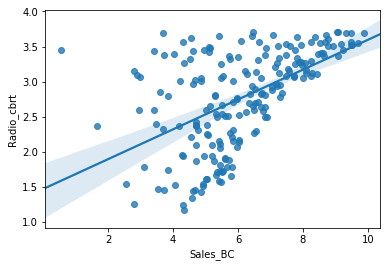

In [176]:
#And the cube root
data['Radio_cbrt'] = np.cbrt(data['Radio'])
sns.regplot(data['Sales_BC'], data['Radio_cbrt'])


In [173]:
# Instantiate and fit our model with transformed Newspaper_BC data.
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Newspaper_BC','Radio_BC']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01543786  0.0107006   0.18328411]

Intercept: 
 1.9954586823

R-squared:
0.879066062416


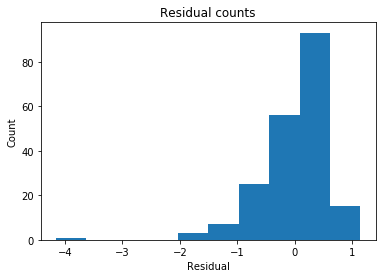

In [174]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [177]:
# Instantiate and fit our model 
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Newspaper_BC','Radio_cbrt']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01540316  0.01603247  1.20925086]

Intercept: 
 0.371326559542

R-squared:
0.869734060935


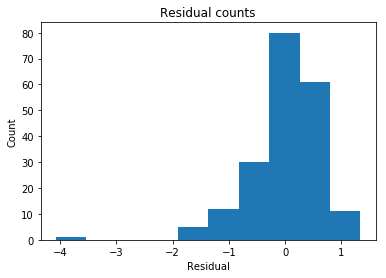

In [178]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [181]:
import math
data['Radio_sqrt'] = [math.sqrt(x) for x in  data['Radio']]

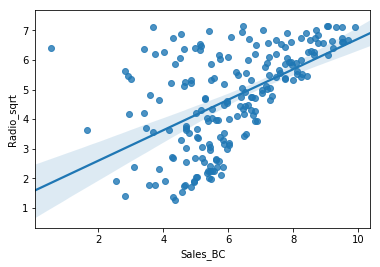

In [183]:
sns.regplot(data['Sales_BC'], data['Radio_sqrt'])
plt.show()

In [184]:
# Instantiate and fit our model 
regr = linear_model.LinearRegression()
Y = data['Sales_BC']
X = data[['TV','Newspaper_BC','Radio_sqrt']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01542465  0.01266346  0.51143424]

Intercept: 
 1.32772909144

R-squared:
0.875973373953


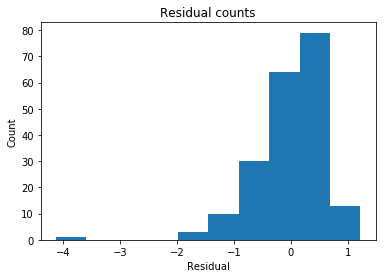

In [185]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales_BC']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

None of the transformations I've tried on radio help our skewed residuals.